# 3 - Final Model Test

This is the moment of truth: we are testing now the final model against an MRA image scan that has not been seen or used for training and tuning of the segmentation process. 

The data for this record have been manually segmented and provide a good indication how well the algorithm will perform against unseen data. 

In [2]:

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import MRASegmentation as mra



/Users/rvh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


No MRA scans are available and nothing can be processed. Set up source data in directory data/source/


Test with the single MRA scan MNI-0663. This record is manually segmented. 

In [3]:

 # only record MNI-663 has not been used for UNET training and hyper-parameter tuning.
# It is (currently) the reliable manually segmented MRA scan to test the final model 
mra_tst = ['MNI_0656','MNI_0663'] 

Load the MRA Segmentation app

In [4]:
app = mra.MRASegmentation()
print('Location of UNet Models: '+app._model_path)

Location of UNet Models: data/models-3/


Load the UNET models 

In [5]:
# load the models 
app._unets.get_models()

Load the test data that is used for the evaluation of the model

In [6]:
l_src_map = np.ndarray(shape=(len(mra_tst),app._no_slices,app._img_height,app._img_height), dtype=np.uint16)  
l_seg_map = np.ndarray(shape=(len(mra_tst),app._no_slices,app._img_height,app._img_height), dtype=np.uint16)  
l_gt_map  = np.ndarray(shape=(len(mra_tst),app._no_slices,app._img_height,app._img_height), dtype=np.uint16)  
i=0
for mra_id in mra_tst: 
    app._mra_id = mra_id
    # Read in 3D MRA source data 
    l_src_map[i] = app.get_3d_mra_source(mra_id) 
    # construct the nine 2D MRA projections 
    mra_src_2Ds = app.get_2d_mra_src_projs(l_src_map[i]) 
    # run the nine unet processes across the image source projections (as trained in Phase 1)
    mra_seg_2Ds = app.get_2d_mra_seg_projs(mra_src_2Ds) 
    # Reconstruct the 3D segmented raw image 
    mra_seg_3D_raw = app.reconstruct_3d_segmentation(mra_seg_2Ds,l_src_map[i]).astype(int)
    # Do the post processing
    l_seg_map[i] = app.post_processing(mra_seg_3D_raw,l_src_map[i]).astype(int)
    # Load the corresponding 3D Ground Truth image 
    l_gt_map[i] = np.sign(app.get_3d_mra_gt(mra_id)).astype(int)
    print('MRA Scan '+mra_id+' 3D processed successfully.') 
    i = i+1
    
    

MRA Scan MNI_0656 3D processed successfully.
MRA Scan MNI_0663 3D processed successfully.


Visualise Ground Truth

In [11]:
idx = 1 # set the index of the record that should be visualised 
l_src = l_src_map[idx]
l_seg = l_seg_map[idx]
l_gt  = l_gt_map[idx]
print(mra_tst[idx])

MNI_0663


In [12]:
from mpl_toolkits.mplot3d import Axes3D

def display_3d_image (data_points, cols):
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(111, projection='3d')
    i = 0
    for dp in data_points.keys():
        ax.scatter(data_points[dp][2], data_points[dp][1], data_points[dp][0], c=cols[i], marker='o',s=0.5)
        i = i + 1

    plt.xlim(0, len(l_seg[1,1,:]))
    plt.ylim(0, len(l_seg[1,:,1]))
    ax.set_xlabel('Image Slices')
    ax.set_ylabel('X Pixel')
    ax.set_zlabel('Y Pixel')

    plt.show()

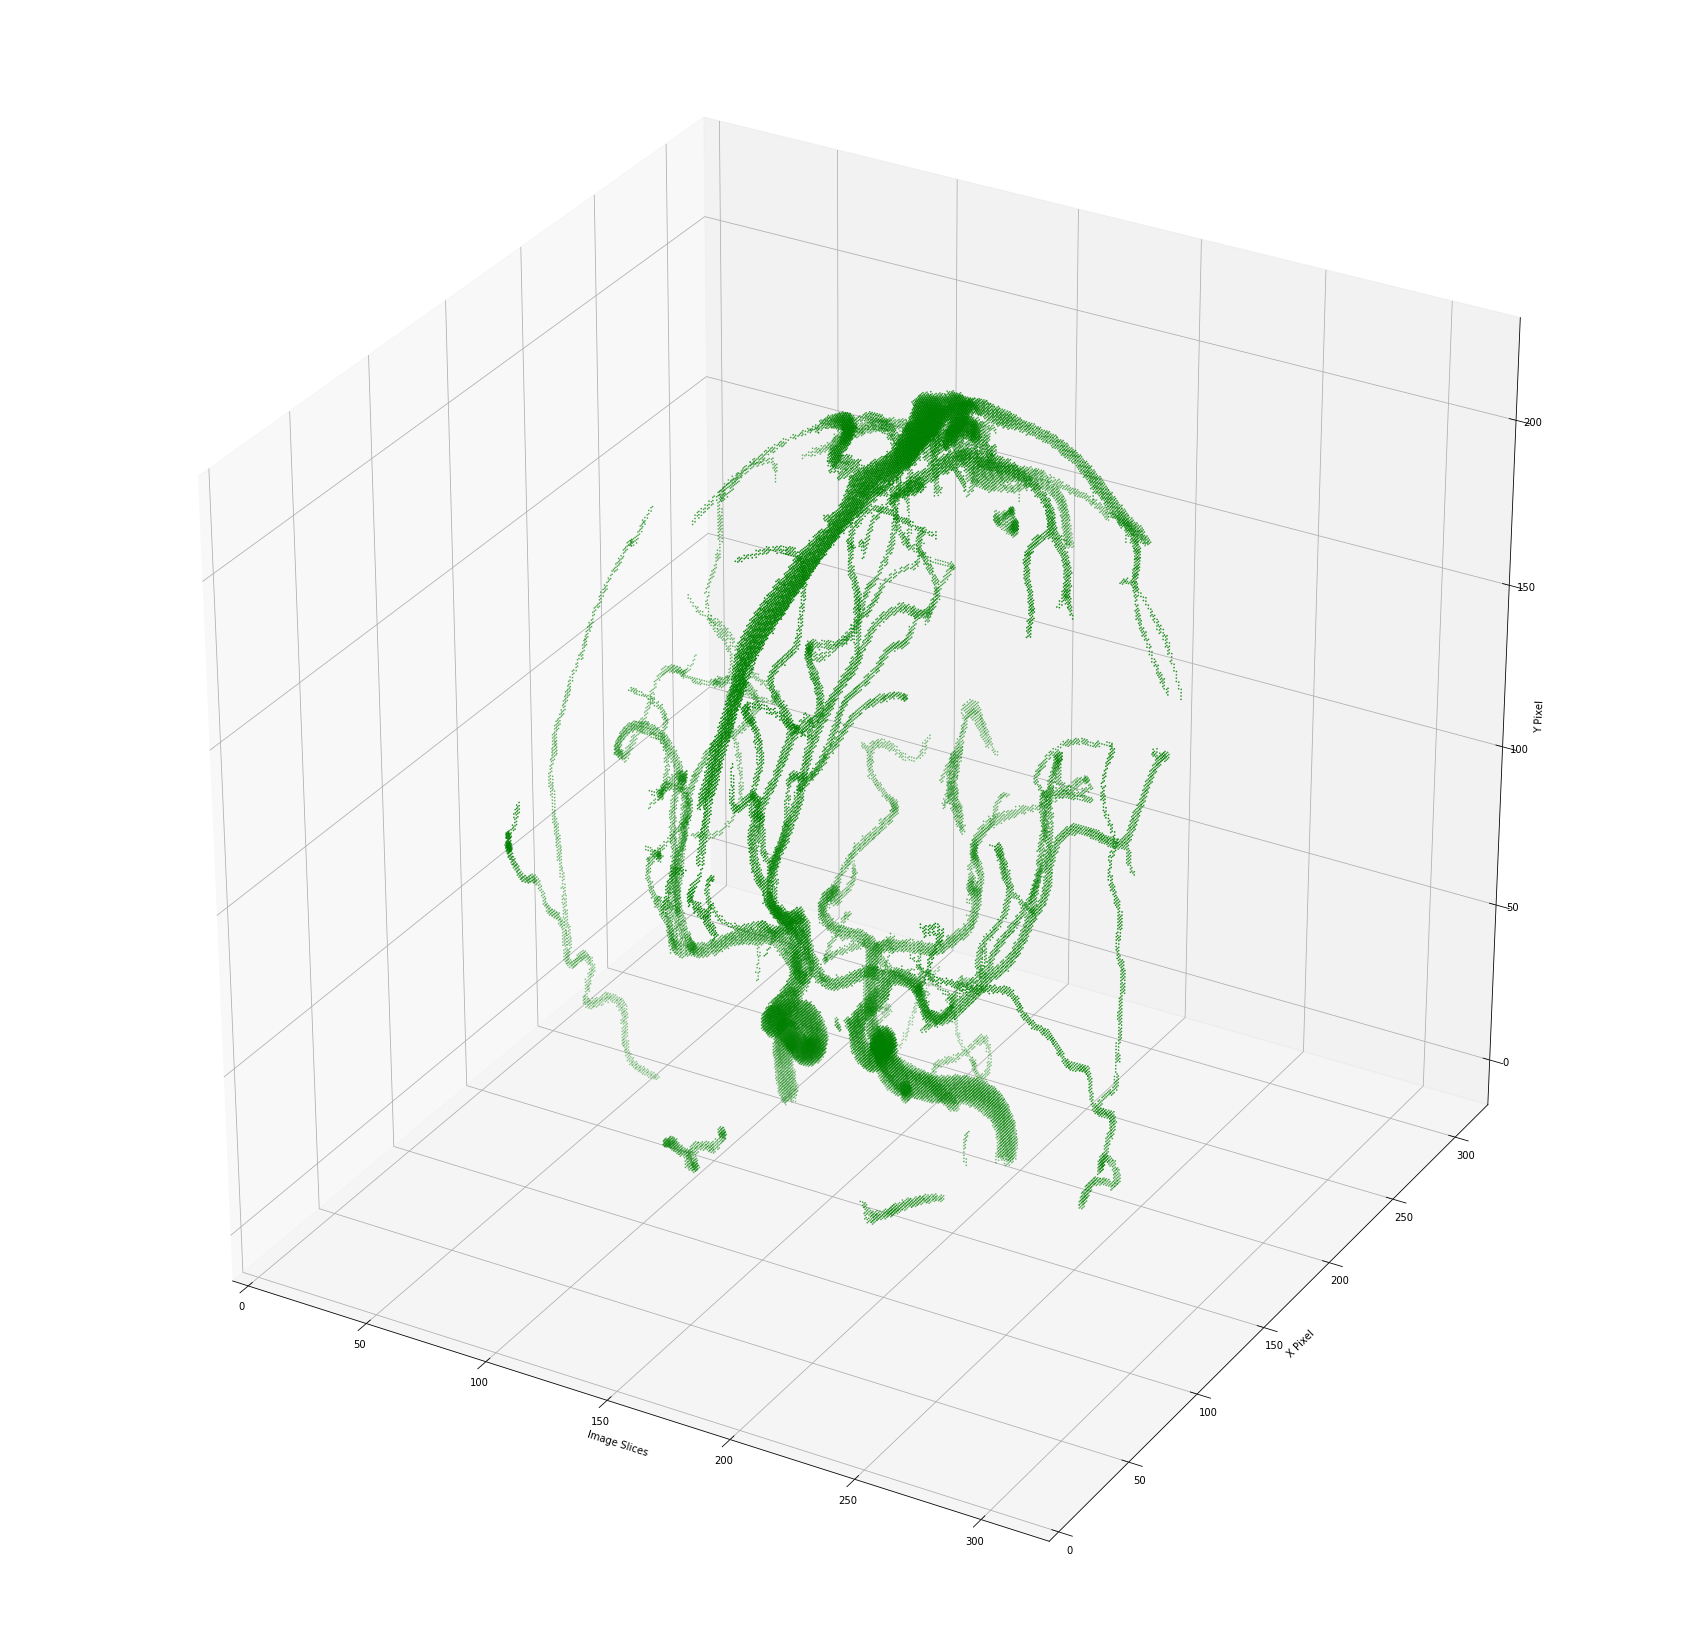

In [13]:
ll = dict()
i = np.equal(l_gt, 1)
ll[0] = np.where(i)

display_3d_image (ll, ['green'])

Visualise Segmented Image

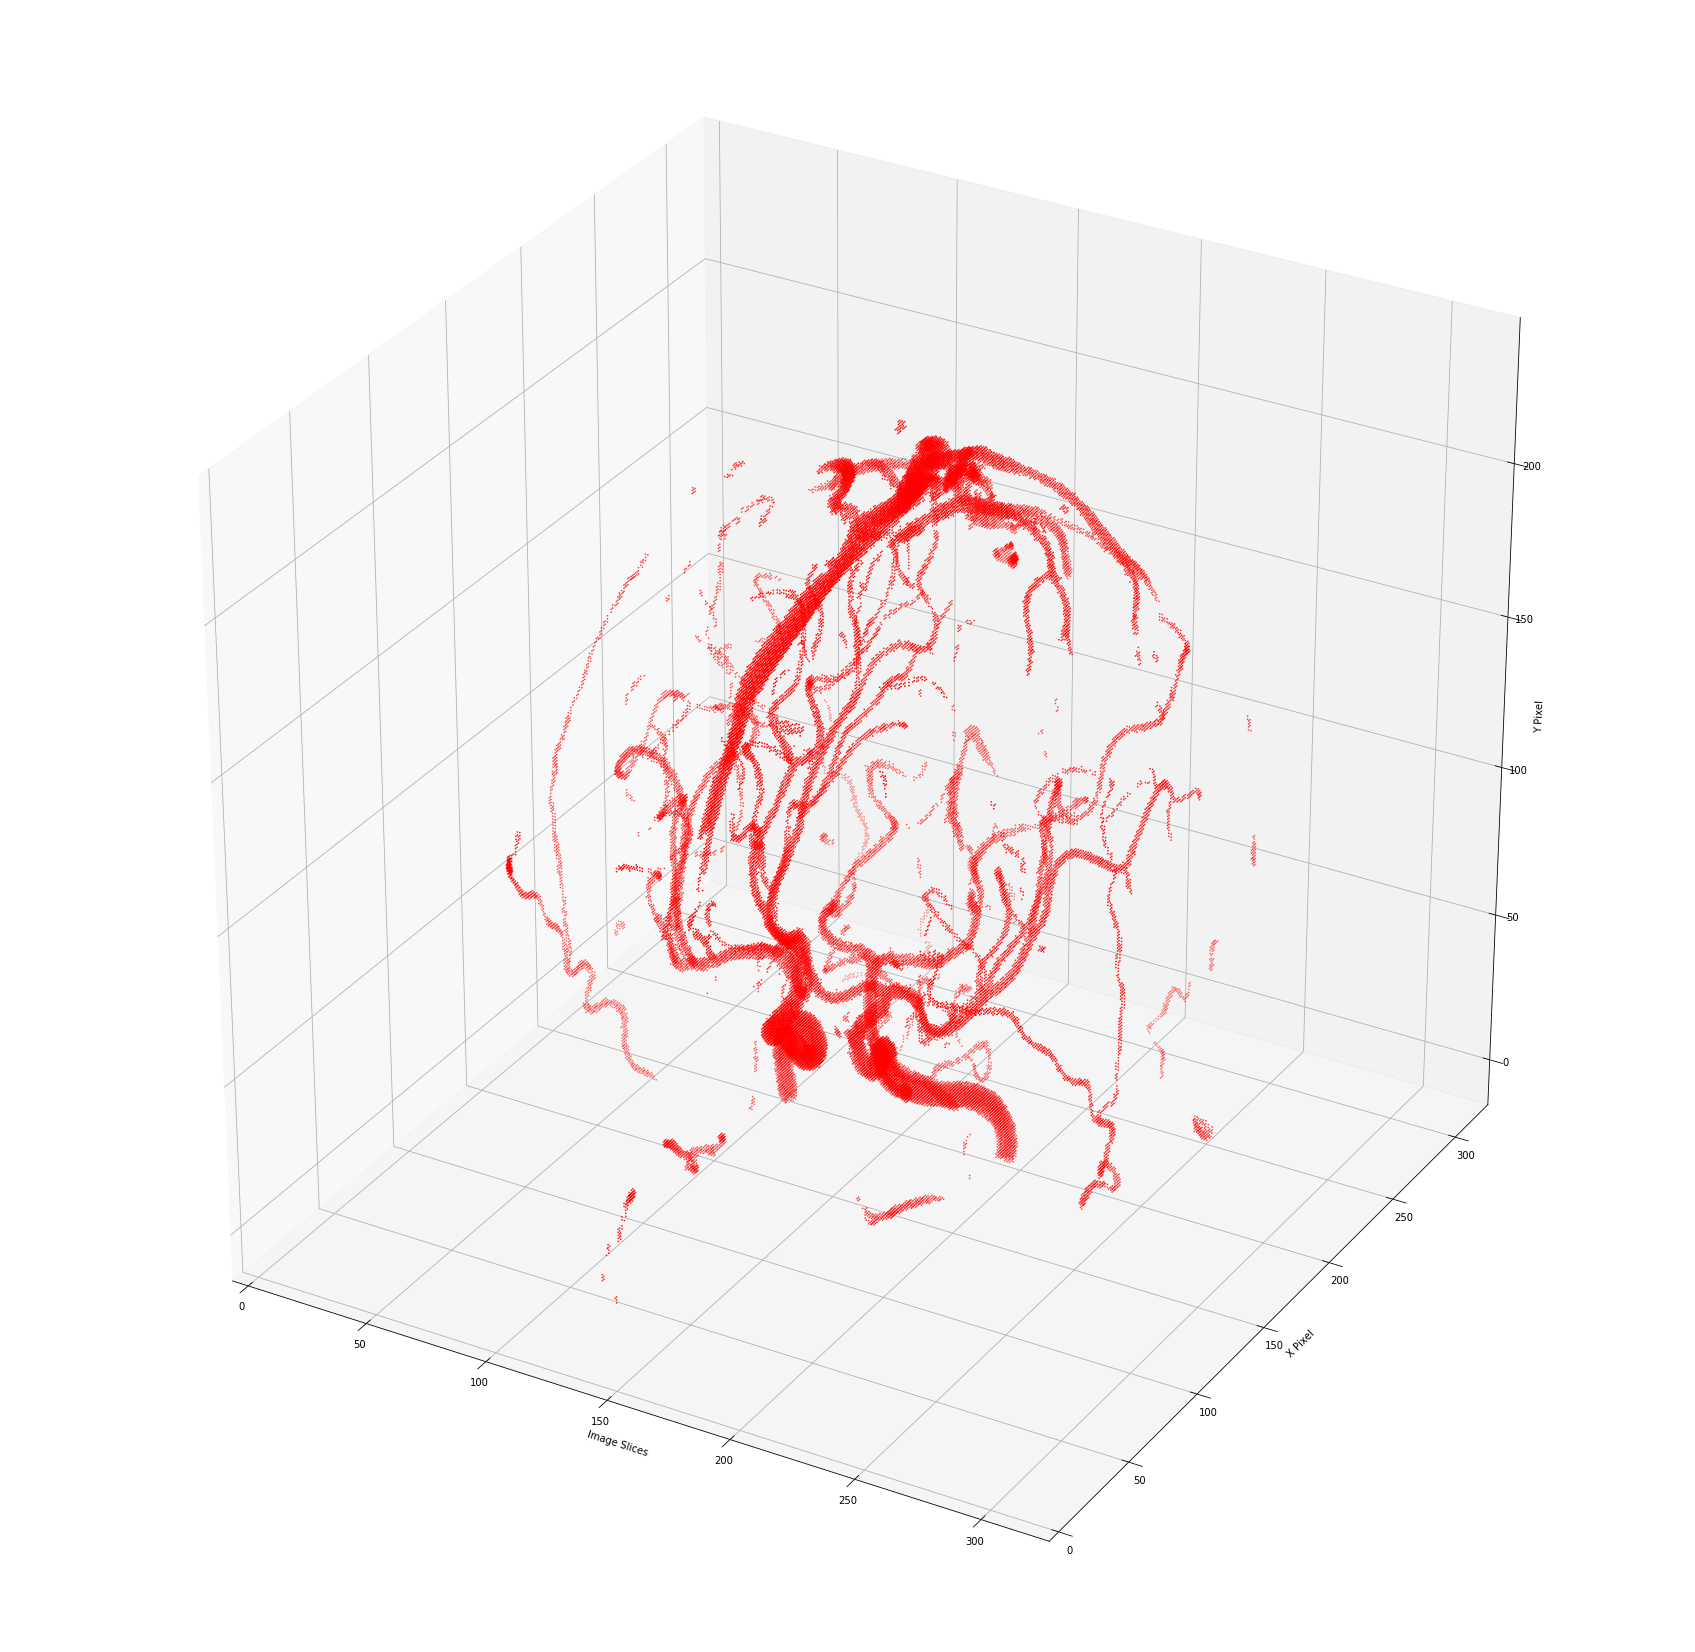

In [14]:

b_map = l_seg.astype(int)

ll = dict()
i = np.equal(b_map, 1)
ll[0] = np.where(i)

display_3d_image (ll, ['red'])

In the final step we create an overlay between ground truth (green) and predicted segmentation map (red). Matching areas are highlighted in yellow, green are GT only sections, and red are predicted sections that are missing in the GT.

FN - Green  - (Blood vessel missed):                  10122
TP - Yellow - (Correctly classified as blood vessel): 46624
FP - Red    - (Wrongly classified as blood vessel):   2846
TN - Opaque - (Correctly classified as background):   25233208
***************************************************************
Total pixel number:                                   25292800
    
Precision:   94.25%
Recall:      82.16%
F1 Score:    87.79%
    


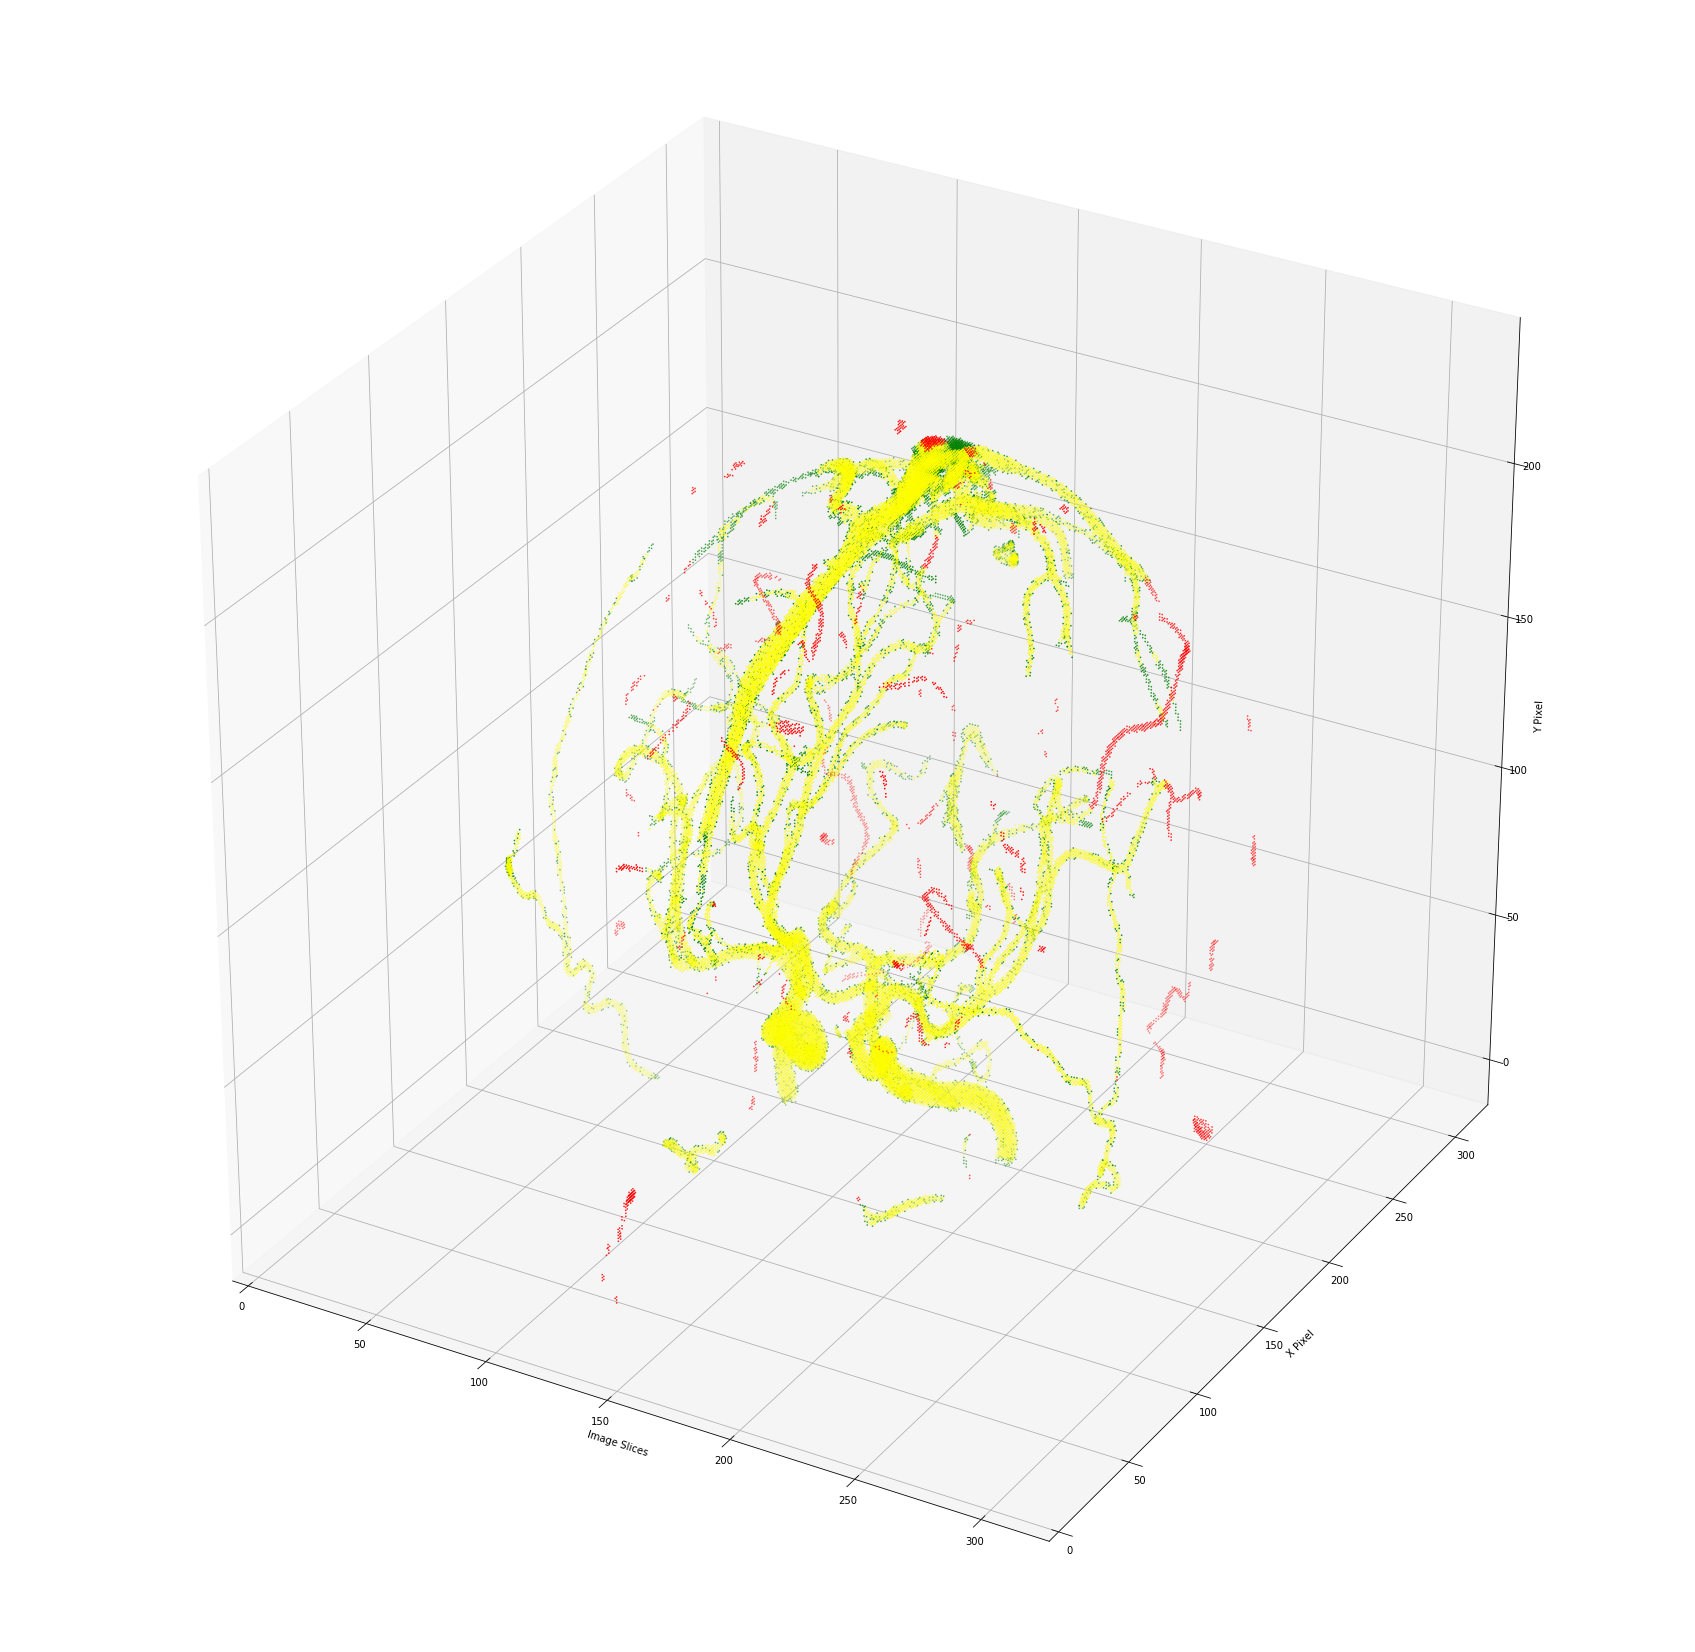

In [15]:

diff = l_gt - (b_map *2)

fn = (diff== 1).sum()
tp = (diff==-1).sum()
fp = (diff==-2).sum()
tn = (diff== 0).sum()
p  = tp / (tp + fp)  # precision 
r  = tp / (tp + fn)  # recall 
f1 = 2*p*r/(p+r)     # F1 score
print('FN - Green  - (Blood vessel missed):                  ' + str(fn) )
print('TP - Yellow - (Correctly classified as blood vessel): ' + str(tp) )
print('FP - Red    - (Wrongly classified as blood vessel):   ' + str(fp) )
print('TN - Opaque - (Correctly classified as background):   ' + str(tn) )
print('***************************************************************')
print('Total pixel number:                                   ' + str(fn+tp+fp+tn))
print('    ')
print('Precision:   ' + str(np.round(100*p,2))+'%')
print('Recall:      ' + str(np.round(100*r,2))+'%')
print('F1 Score:    ' + str(np.round(100*f1,2))+'%')
print('    ')

ll = dict()
idx = np.equal(diff, 1) # missed blood vessels
ll[0] = np.where(idx)

idx = np.equal(diff, -2) # wrongly assigned blood vessels
ll[1] = np.where(idx)


idx = np.equal(diff, -1) # correctly assigned blood vessels
ll[2] = np.where(idx)

display_3d_image (ll, ['green','red','yellow'])


Model 1: 


565: p = 90.4, r = 96.1, f = 93.2

663: p = 93.9, r = 82.7, f = 87.9

Model 2: 

565: p = 90.1, r = 94.8, f = 92.4

663: p = 93.5, r = 83.7, f = 88.4


Model 3A: 

565: p = 90.8, r = 95.4, f = 93.0

663: p = 94.2, r = 82.2, f = 87.8

Model 4: 

565: p = 90.5,  r = 96.1, f = 93.2

663: p = 93.9, r = 82.7, f = 87.9

Model 5:

565: p = 90.5,  r = 88.5, f = 89.5

663: p = 94.1, r = 80.6, f = 86.8


End of the Test Phase (and the entire project!!!)